# OIS Yield Curve Construction 

Constructing the OIS yield curve can be done via mid-quotes of market makers. The OIS curve can be constructed entirely from OIS instruments. For this yield curve construction we aim to find the OIS forward rate which can be found by discritizing the forward curve into daily rates, and fitting these to the zero-rates found by bootstrapping.

Thus, the construction is based on optimzation and not interpolation. 

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from amplpy import AMPL, Environment

path = "ampl/mac/ampl_macos64/"
ampl = AMPL(Environment(path))

%config InlineBackend.figure_format = 'retina'
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

In order to bootstrap the OIS swap rates into continuously compounded zero rates we must import the data and compute the mid rates.

### Loading Swap Rates into DataFrames & Bootstrapping

In [130]:
df_mid = pd.read_excel("data/forwardRates.xlsx", sheet_name="MID")

In [131]:
dt = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
T = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [132]:
def bootstrap(swap_rates: np.array, dt: np.array, T: np.array) -> np.array:
    number_of_rates = len(swap_rates)
    zero_rates = np.zeros(number_of_rates)
    for i in range(number_of_rates):
        if T[i] <= 1:
            zero_rates[i] = 1/T[i] * np.log(1 + swap_rates[i] * dt[i])
        else:
            zero_rates[i] = 1/T[i] * np.log((1 + swap_rates[i] * dt[i]) / (1 - swap_rates[i] * np.sum(np.exp(-zero_rates[:i-1]*T[:i-1]) * dt[:i-1])))
    return zero_rates

In [133]:
swap_rates = np.array(df_mid.loc[1].values[1:])/100
zero_rates = bootstrap(swap_rates, dt, T)

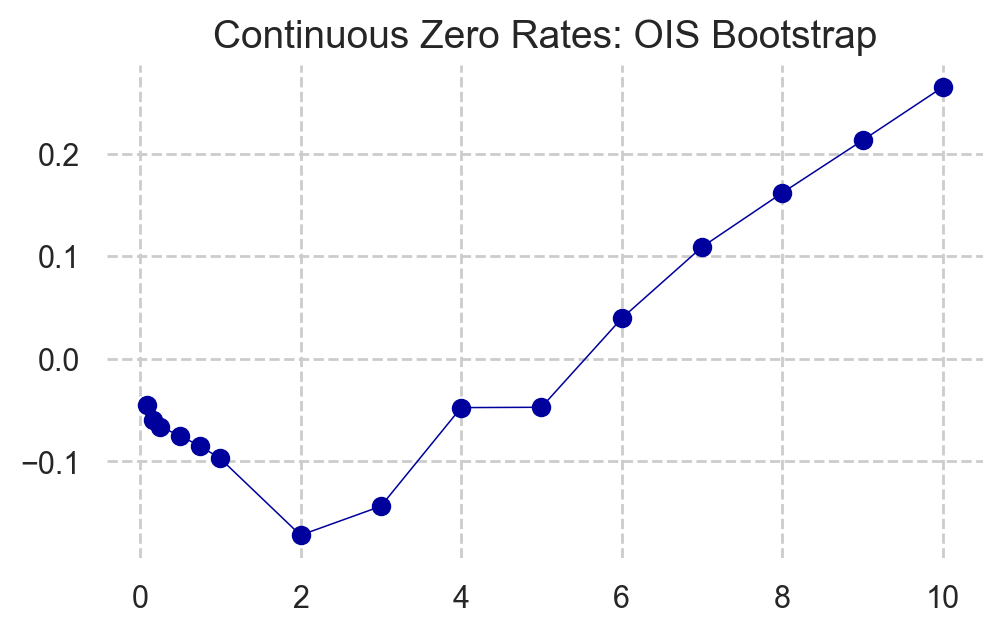

In [134]:
fig, ax = plt.subplots()
ax.plot(T, zero_rates*100, lw=0.55)
ax.scatter(T, zero_rates*100)
ax.set_title("Continuous Zero Rates: OIS Bootstrap", fontsize=14)
ax.set_frame_on(False)
fig.tight_layout()
fig.set_size_inches(5, 3)
plt.show()

### Constructing Yield Curve without Regularization

In [135]:
def search_yc(swap_rates):
    zero_rates = bootstrap(swap_rates, dt, T)
    ampl = AMPL(Environment(path))
    ampl.read('ampl_models/forwardRates.mod')

    # Setting all parameters needed in the AMPL mod file.
    ampl.get_parameter('dt').set(1/365)
    ampl.get_parameter('n').set(365*10)
    ampl.get_parameter('m').set(len(T))
    ampl.get_parameter('M').setValues(T)
    ampl.get_parameter('r').setValues(zero_rates)

    # Seeting the solver.
    ampl.setOption('solver', "ampl/mac/ampl_macos64/ipopt")

    # Solving.
    ampl.solve()

    # Fetching solution.
    f = ampl.get_variable("f").get_values()

    return f.get_column("f.val").to_list()

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    20711
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10947

Total number of variables............................:     3650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


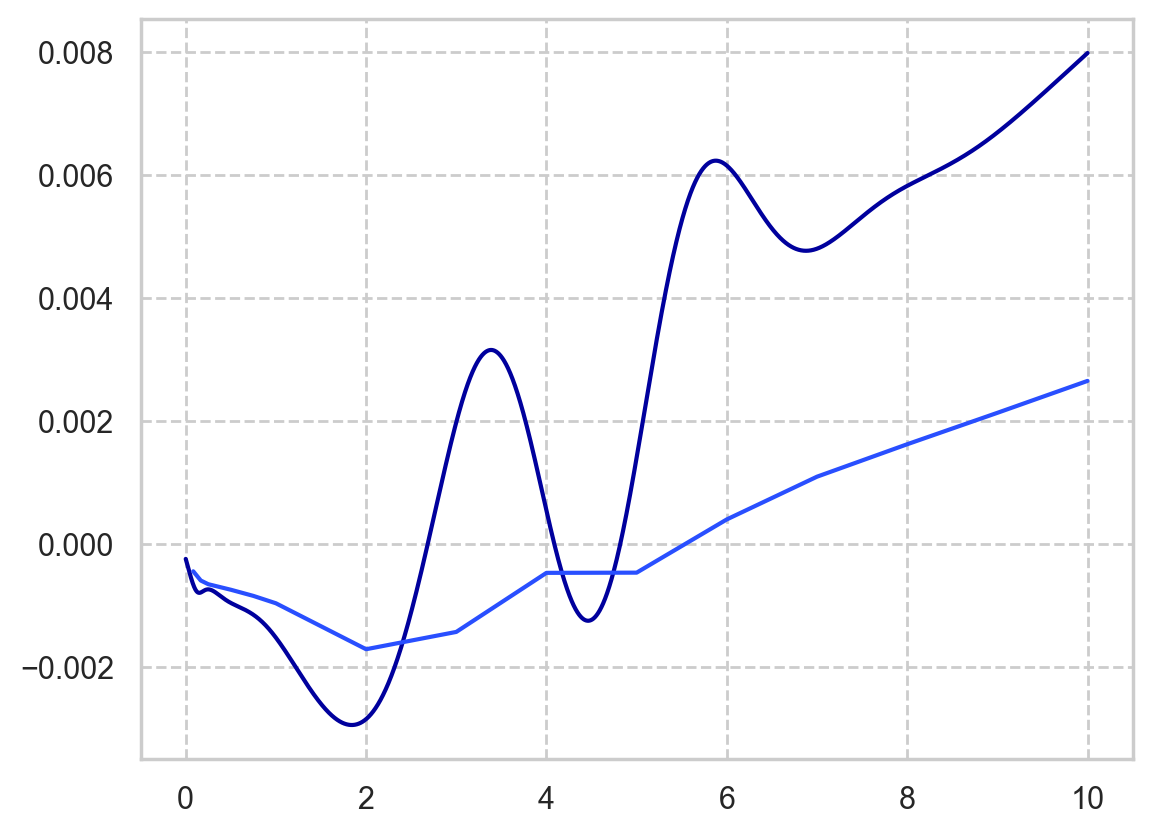

In [136]:
fS = search_yc(swap_rates)
ampl.close()
plt.plot(np.linspace(0, 10, len(fS)), fS)
plt.plot(T, zero_rates)
plt.show()

### Constructing Yield Curve with Regularization

In [137]:
def serach_yc_regularization(swap_rates, p=1e-1):
    zero_rates = bootstrap(swap_rates, dt, T)
    ampl = AMPL(Environment(path))
    ampl.read('ampl_models/forwardRatesLS.mod')

    # Setting all parameters needed in the AMPL mod file.
    ampl.get_parameter('p').set(1e-7)
    ampl.get_parameter('dt').set(1/365)
    ampl.get_parameter('n').set(365*10)
    ampl.get_parameter('m').set(len(T))
    ampl.get_parameter('M').setValues(T)
    ampl.get_parameter('r').setValues(zero_rates)

    # Seeting the solver.
    ampl.setOption('solver', "ampl/mac/ampl_macos64/ipopt")

    # Solving.
    ampl.solve()

    # Fetching solution.
    f = ampl.get_variable("f").get_values()
    z = ampl.get_variable("z").get_values()

    return f.get_column("f.val").to_list()

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    20726
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10962

Total number of variables............................:     3665
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


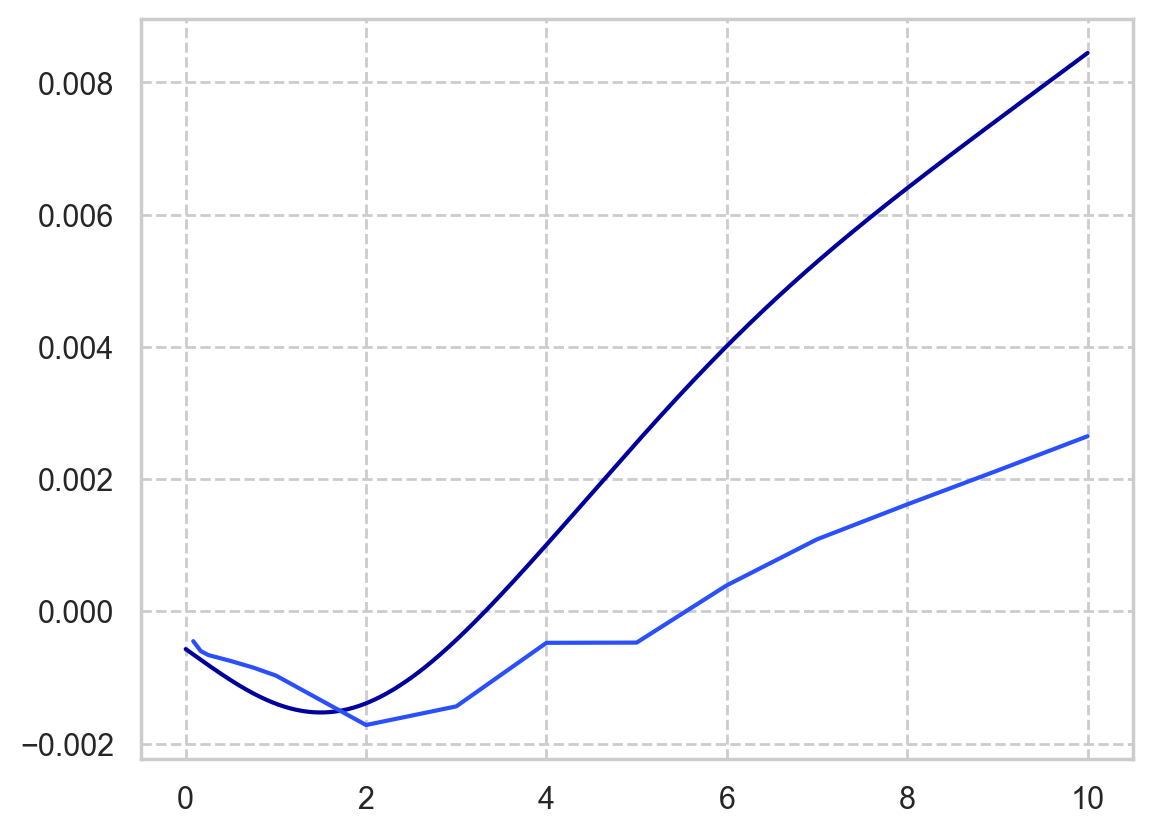

In [138]:
fS = serach_yc_regularization(swap_rates)
plt.plot(np.linspace(0, 10, len(fS)), fS)
plt.plot(T, zero_rates)
plt.show()

### Comparing the Smoothness of the Yield Curve Construction Methods

In [230]:
ycs = []
ycs_reg = []
for i in range(24):
    swap_rates = np.array(df_mid.loc[i].values[1:])/100
    ycs.append(search_yc(swap_rates))
    ycs_reg.append(serach_yc_regularization(swap_rates))

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    20711
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10947

Total number of variables............................:     3650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


In [231]:
def plot_yc(yc: np.array, ax):
    
    X = np.array([i for i in range(len(yc))])
    Y = np.array([j/365 for j in range(len(yc[0]))])
    Z = np.array(yc)

    X, Y = np.meshgrid(Y, X)
    Z = np.array(Z)*100

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.view_init(20, -75)
    ax.view_init(15, -135)
    ax.set_frame_on(False)


    # Remove gray panes in 3D plots. Replacing with a white color.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax.plot_surface(X, Y, Z , cmap='jet', edgecolor='none')

/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_47366/3433639121.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(dates)
/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_47366/3433639121.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(dates)


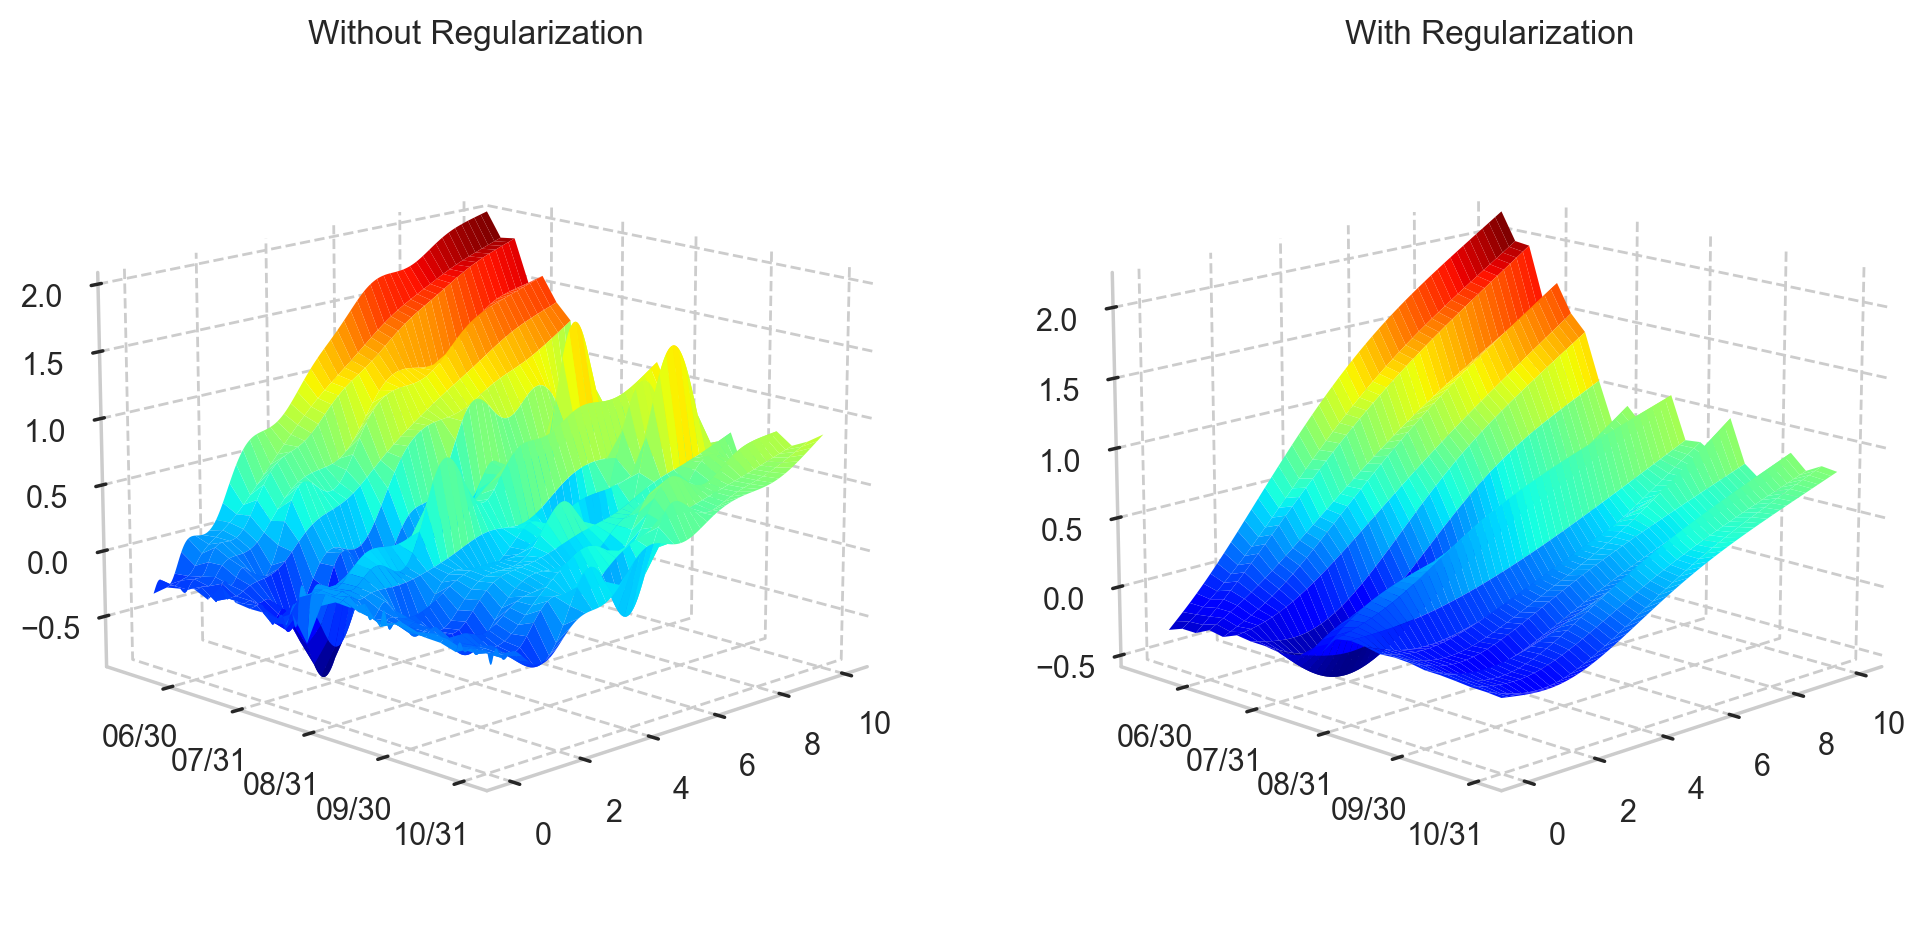

In [237]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'))

ax[0].set_title("Without Regularization")
ax[1].set_title("With Regularization")


dates = [str(date)[5:10].replace("-", "/") for date in df_mid["Date"]]

ax[1].set_yticklabels(dates)
ax[0].set_yticklabels(dates)
#ax[0].set_xticks(T)
#ax[0].set_xticklabels(tenors)

plot_yc(ycs, ax[0])
plot_yc(ycs_reg, ax[1])

#fig.tight_layout()
fig.set_size_inches(12, 10)
plt.show()

### PCA: Yield Curve Driving Factors